<a href="https://colab.research.google.com/github/two-twentyseven/power-outages-analysis/blob/main/outages_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Outage Analyzanator

**Name(s)**: Jocelyn Ng, Holden Flett

**Website Link**: https://jocelynng101.github.io/power-outages-analysis/

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
pd.options.plotting.backend = 'plotly'

N = 10000

#from dsc80_utils import * # Feel free to uncomment and use this.

#Preferred Template
pio.templates["dsc80"] = go.layout.Template(
    layout=dict(
        margin=dict(l=30, r=30, t=30, b=30),
        autosize=True,
        width=600,
        height=400,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+dsc80"

import plotly.figure_factory as ff
def create_kde_plotly(df, group_col, group1, group2, vals_col, title=''):
    fig = ff.create_distplot(
        hist_data=[df.loc[df[group_col] == group1, vals_col], df.loc[df[group_col] == group2, vals_col]],
        group_labels=[group1, group2],
        show_rug=False, show_hist=False
    )
    return fig.update_layout(title=title)

In [ ]:
#Download this in order to read in the excel file
#pip install openpyxl

## Step 1: Introduction

### Brainstorm of questions
     1) Is there a statistical correlation between higher electricity consumption and severity of the outage?
     2) Are higher severity outages more common in wealthier areas or poorer areas?
     3) What times are the highest severity outages happening at? Is there a trend?
     4) Perhaps we will add more questions later !!!

 ### Final Question
 What are the characteristics of major power outages with higher severity?

## Step 2: Data Cleaning and Exploratory Data Analysis

In [ ]:
#Data Cleaning
#Upload dataset
outages_path = Path('data')/'outage.xlsx'

#Skip the first five rows so the column titles are in the first row and skip the row containing all of the column units
skip_rows = list(range(5)) + [6]
#1) Load the dataset using pd.read_excel
outages = pd.read_excel(
    outages_path,
    skiprows=skip_rows,
    )
#Note that outages originally has 1540 rows and 57 columns before cleaning
outages

,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,NaN,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
1,NaN,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
2,NaN,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
3,NaN,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
4,NaN,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,...,73.27,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,NaN,1530,2011,12.0,North Dakota,ND,MRO,West North Central,-0.9,cold,...,59.90,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765
1530,NaN,1531,2006,NaN,North Dakota,ND,MRO,West North Central,NaN,NaN,...,59.90,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765
1531,NaN,1532,2009,8.0,South Dakota,SD,RFC,West North Central,0.5,warm,...,56.65,26.73,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256
1532,NaN,1533,2009,8.0,South Dakota,SD,MRO,West North Central,0.5,warm,...,56.65,26.73,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256


In [ ]:
# 2) Drop all of the columns that are not relevant for analyzing "what are the characteristics of major power outages with higher severity?
# Variables to consider include: location, time, climate, land-use characteristics, electricity consumption patterns, economic characteristics
# Since we iterated through all categorical columns in scanning for correlations through R^2, the only columns we didn't use are the time columns,
# the U.S. postal code (redundancy), and the column variables, but we will keep the time columns for the project's datetime requirement (rubric)

outages = outages.drop(columns=["variables", "POSTAL.CODE"], errors="ignore")
outages = outages.set_index("OBS")
outages['DUR.LOG'] = np.log(outages['OUTAGE.DURATION'] + 1) #Adding logged duration to understand duration more easily despite the skew (later used as a prediction target)

outages

,YEAR,MONTH,U.S._STATE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,OUTAGE.START.TIME,OUTAGE.RESTORATION.DATE,...,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,DUR.LOG
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7.0,Minnesota,MRO,East North Central,-0.3,normal,2011-07-01,17:00:00,2011-07-03,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,8.026497
2,2014,5.0,Minnesota,MRO,East North Central,-0.1,normal,2014-05-11,18:38:00,2014-05-11,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,0.693147
3,2010,10.0,Minnesota,MRO,East North Central,-1.5,cold,2010-10-26,20:00:00,2010-10-28,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,8.006701
4,2012,6.0,Minnesota,MRO,East North Central,-0.1,normal,2012-06-19,04:30:00,2012-06-20,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,7.844241
5,2015,7.0,Minnesota,MRO,East North Central,1.2,warm,2015-07-18,02:00:00,2015-07-19,...,15.28,2279.0,1700.5,18.2,2.14,0.60,91.592666,8.407334,5.478743,7.462215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,2011,12.0,North Dakota,MRO,West North Central,-0.9,cold,2011-12-06,08:00:00,2011-12-06,...,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,6.580639
1531,2006,NaN,North Dakota,MRO,West North Central,NaN,NaN,NaT,NaN,NaT,...,19.90,2192.2,1868.2,3.9,0.27,0.10,97.599649,2.401765,2.401765,NaN
1532,2009,8.0,South Dakota,RFC,West North Central,0.5,warm,2009-08-29,22:54:00,2009-08-29,...,26.73,2038.3,1905.4,4.7,0.30,0.15,98.307744,1.692256,1.692256,4.094345


In [ ]:
# 3) Combine 'OUTAGE.START.DATE' and 'OUTAGE.START.TIME' into 'OUTAGE.START'
outages['OUTAGE.START'] = pd.to_datetime(
    outages['OUTAGE.START.DATE']
) + pd.to_timedelta(
    outages['OUTAGE.START.TIME'].astype(str)
)

# 4) Combine 'OUTAGE.RESTORATION.DATE' and 'OUTAGE.RESTORATION.TIME' into 'OUTAGE.RESTORATION'

outages['OUTAGE.RESTORATION'] = pd.to_datetime(
    outages['OUTAGE.RESTORATION.DATE']
) + pd.to_timedelta(
    outages['OUTAGE.RESTORATION.TIME'].astype(str)
)

# 5) Dropped the columns we previously combined into 'OUTAGE.START' and 'OUTAGE.RESTORATION'
outages = outages.drop(columns=[
    'OUTAGE.START.DATE',
    'OUTAGE.START.TIME',
    'OUTAGE.RESTORATION.DATE',
    'OUTAGE.RESTORATION.TIME'
])


In [ ]:
# Print the first 5 rows of the entire dataframe as Markdown
print(outages.head().to_markdown(index=False))

|   YEAR |   MONTH | U.S._STATE   | NERC.REGION   | CLIMATE.REGION     |   ANOMALY.LEVEL | CLIMATE.CATEGORY   | CAUSE.CATEGORY     | CAUSE.CATEGORY.DETAIL   |   HURRICANE.NAMES |   OUTAGE.DURATION |   DEMAND.LOSS.MW |   CUSTOMERS.AFFECTED |   RES.PRICE |   COM.PRICE |   IND.PRICE |   TOTAL.PRICE |   RES.SALES |   COM.SALES |   IND.SALES |   TOTAL.SALES |   RES.PERCEN |   COM.PERCEN |   IND.PERCEN |   RES.CUSTOMERS |   COM.CUSTOMERS |   IND.CUSTOMERS |   TOTAL.CUSTOMERS |   RES.CUST.PCT |   COM.CUST.PCT |   IND.CUST.PCT |   PC.REALGSP.STATE |   PC.REALGSP.USA |   PC.REALGSP.REL |   PC.REALGSP.CHANGE |   UTIL.REALGSP |   TOTAL.REALGSP |   UTIL.CONTRI |   PI.UTIL.OFUSA |   POPULATION |   POPPCT_URBAN |   POPPCT_UC |   POPDEN_URBAN |   POPDEN_UC |   POPDEN_RURAL |   AREAPCT_URBAN |   AREAPCT_UC |   PCT_LAND |   PCT_WATER_TOT |   PCT_WATER_INLAND |   DUR.LOG | OUTAGE.START        | OUTAGE.RESTORATION   |
|-------:|--------:|:-------------|:--------------|:-------------------|---------------

In [ ]:
fig1 = px.histogram(
    outages[outages['OUTAGE.DURATION'] >= 0],
    x='DUR.LOG',
    nbins=50,
    title='Natural Log Distribution of Power Outage Durations',
    labels={'OUTAGE.DURATION': 'Outage Duration (minutes)'},
    # 1. Change color to match the screenshot's periwinkle blue
    color_discrete_sequence=['#636EFA'],
    # 2. Apply the seaborn template for the grey background/white grid
    template='seaborn'
)
fig1.update_layout(
    showlegend=False,
    height=500,
    width=800,  # <--- Add this line to stop it from stretching
    font_family="Arial",
    font_color="#2c3e50",
    title_font_size=20
)

In [ ]:
import os

# 1. Prepare Data
counts = outages['CAUSE.CATEGORY'].value_counts().reset_index()
counts.columns = ['Cause Category', 'Count']

# 2. Define Colors
reference_blue = '#636EFA'
reference_title_color = '#2a3f5f'

# 3. Create Plotly Figure
fig = px.bar(
    counts,
    x='Cause Category',
    y='Count',
    template='plotly'
)

# 4. Apply Custom Styling
fig.update_traces(marker_color=reference_blue)

fig.update_layout(
    title=dict(
        text='Number of Outages per Cause Category',
        font=dict(color=reference_title_color, size=20)
    ),
    xaxis=dict(
        title='Cause Category',
        tickangle=-45
    ),
    yaxis=dict(title='Count'),
    margin=dict(b=150)
)

# 5. Save as HTML
if not os.path.exists("assets"):
    os.makedirs("assets")

fig.write_html("assets/cause_category_plot.html", include_plotlyjs='cdn')

fig.show()

In [ ]:

# 1. Prepare Data
# We count the values for 'CLIMATE.REGION' and sort them (handled automatically by value_counts)
counts = outages['CLIMATE.REGION'].value_counts().reset_index()
counts.columns = ['Climate Region', 'Count']

# 2. Define Colors (matching your snippet)
reference_blue = '#636EFA'
reference_title_color = '#2a3f5f'

# 3. Create Plotly Figure
fig = px.bar(
    counts,
    x='Climate Region',
    y='Count',
    template='plotly' # Matches the 'darkgrid' style
)

# 4. Apply Custom Styling
fig.update_traces(marker_color=reference_blue)

fig.update_layout(
    # Matches: fontweight='bold' and color=reference_title_color from your snippet
    title=dict(
        text='Number of Outages per Climate Region',
        font=dict(color=reference_title_color, size=20)
    ),
    xaxis=dict(
        title='Climate Region',
        tickangle=-45 # Matches rotation=45
    ),
    yaxis=dict(title='Count'),
    margin=dict(b=150) # Adds margin for rotated labels
)

# 5. Save as HTML
if not os.path.exists("assets"):
    os.makedirs("assets")

fig.write_html("assets/climate_region_plot.html", include_plotlyjs='cdn')
fig.show()

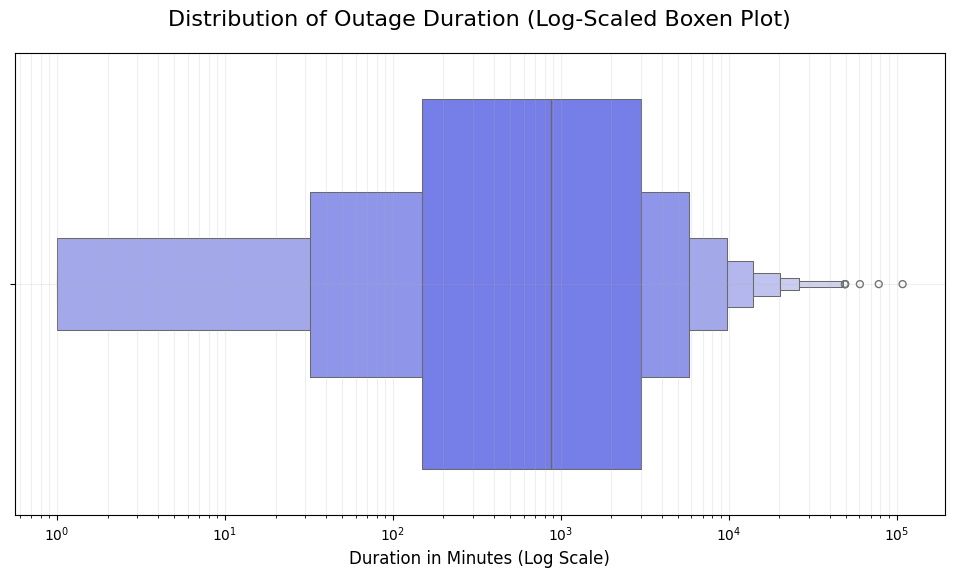

In [ ]:
# --- Plot 2: Boxen Plot of Duration (Log Scale) ---


# Better than a boxplot for heavy-tailed distributions (lots of outliers)
plt.figure(figsize=(12, 6))

# We drop NA and 0 values to avoid log errors
duration_data = outages.dropna(subset=['OUTAGE.DURATION'])
duration_data = duration_data[duration_data['OUTAGE.DURATION'] > 0]

sns.boxenplot(
    x=duration_data['OUTAGE.DURATION'],
    color="#636EFA" # Matches Plotly default blue
)

plt.xscale('log') # Log scale is crucial here to see the spread
plt.title('Distribution of Outage Duration (Log-Scaled Boxen Plot)', fontsize=16, pad=20)
plt.xlabel('Duration in Minutes (Log Scale)', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

In [ ]:
# Bivariate Analysis

#Seasonal Density Heatmap
# Shows the frequency of outages across Years and Months

fig_heatmap = px.density_heatmap(
    outages,
    x="MONTH",
    y="YEAR",
    nbinsx=12, # Force 12 bins for months
    nbinsy=len(outages['YEAR'].unique()), # One bin per year
    color_continuous_scale='viridis',
    title="Heatmap of Power Outage Frequency (Year vs. Month)",
    labels={'MONTH': 'Month of Year', 'YEAR': 'Year'}
)

# Fix axis formatting to show every year/month clearly
fig_heatmap.update_xaxes(dtick=1, tickmode='linear')
fig_heatmap.update_yaxes(dtick=1, tickmode='linear')

fig_heatmap.update_layout(
    height=600,
    font_family="Open Sans, verdana, arial, sans-serif"
)

fig_heatmap.show()

In [ ]:
# import os

# # Create an 'assets' folder if it doesn't exist yet
# if not os.path.exists("assets"):
#     os.mkdir("assets")

# # Save the figure as an HTML file in the assets folder
# fig_heatmap.write_html("assets/UniHeatmap.html", include_plotlyjs='cdn')

In [ ]:

# Create the Scatterplot (Your provided code)
fig = px.scatter(
    outages,
    x='CUSTOMERS.AFFECTED',
    y='OUTAGE.DURATION',
    title='Outage Duration vs Customers Affected',
    labels={
        'CUSTOMERS.AFFECTED': 'Customers Affected',
        'OUTAGE.DURATION': 'Outage Duration (minutes)'
    },
    opacity=0.6,
    template='seaborn',
    color_discrete_sequence=['#636EFA', '#EF553B']
)

fig.update_layout(
    height=500,
    width=800,
    font_family="Arial",
    font_color="#2c3e50",
    title_font_size=20
)

# Save the chart to HTML
fig.write_html("outage_scatterplot.html")

fig.show()

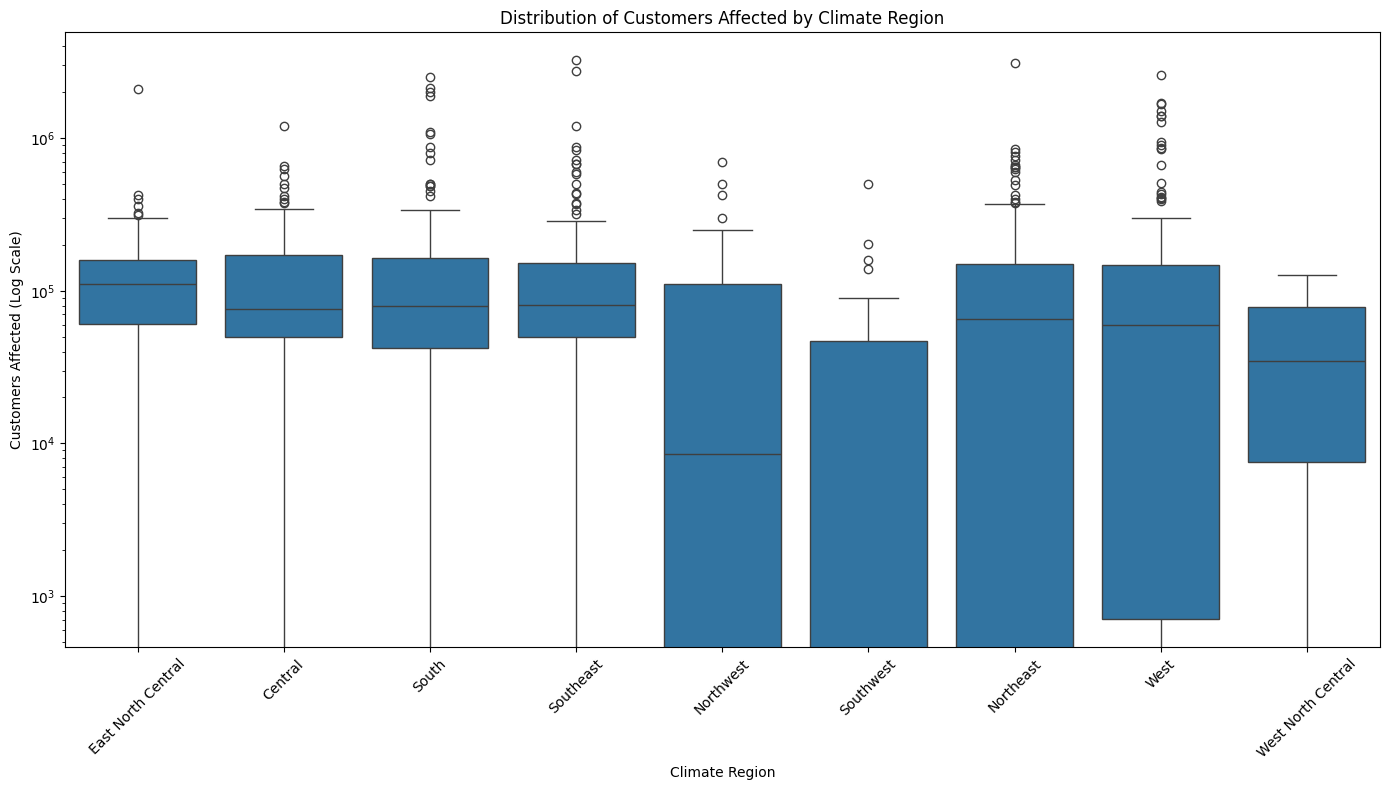

In [ ]:

# Load the dataset
# Ensure the file 'outage_cleaned (2).csv' is in your current working directory
df=outages
# Prepare the data
# We drop rows where either 'CUSTOMERS.AFFECTED' or 'CLIMATE.REGION' is missing (NaN)
plot_data = df.dropna(subset=['CUSTOMERS.AFFECTED', 'CLIMATE.REGION']).copy()

# Create the figure
plt.figure(figsize=(14, 8))

# Create the box plot
# x: Categorical variable (Climate Region)
# y: Numerical variable (Customers Affected)
sns.boxplot(x='CLIMATE.REGION', y='CUSTOMERS.AFFECTED', data=plot_data)

# Set the y-axis to a logarithmic scale
# This is important because the number of customers affected varies widely (from small to very large)
plt.yscale('log')

# Rotate x-axis labels to prevent overlapping
plt.xticks(rotation=45)

# Set the chart title and axis labels
plt.title('Distribution of Customers Affected by Climate Region')
plt.ylabel('Customers Affected (Log Scale)')
plt.xlabel('Climate Region')

# Adjust the layout to fit everything neatly
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:

# 1. Create the Boolean column for Missingness
outages['is_missing'] = outages['DEMAND.LOSS.MW'].isna()

# 2. Create the Histogram with the requested theme
fig = px.histogram(
    outages,
    x='DUR.LOG',
    color='is_missing',
    histnorm='probability',   # Normalizes height to probability density
    barmode='overlay',        # Overlays the two distributions
    opacity=0.75,             # Transparency
    title='Distribution of DUR.LOG by Missingness of DEMAND.LOSS.MW',
    labels={'is_missing': 'DEMAND.LOSS.MW Missing?'},

    # --- Theming from your snippet ---
    template='seaborn',       # Applies the grey background/white grid
    # Starts with Periwinkle Blue (#636EFA), adds Red (#EF553B) for the second group
    color_discrete_sequence=['#636EFA', '#EF553B']
)

# 3. Apply the specific Layout settings
fig.update_layout(
    height=500,
    width=800,
    font_family="Arial",
    font_color="#2c3e50",
    title_font_size=20,

    # Legend positioning (optional, keeps it neat)
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="right",
        x=0.99
    )
)

fig.show()

In [ ]:
#Interesting Aggregates
# 1. Group by NERC Region and print markdown
nerc_stats = df.groupby('NERC.REGION')[['OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW']].mean()
print("### NERC Region Statistics")
print(nerc_stats.to_markdown())
print("\n") # Add spacing

# 2. Pivot Table: Climate Region vs Cause Category and print markdown
# Note: We reset the index or use a specific print to make sure the headers align nicely in markdown
climate_cause_pivot = df.pivot_table(
    index='CLIMATE.REGION',
    columns='CAUSE.CATEGORY',
    values='OUTAGE.DURATION',
    aggfunc='mean'
)
print("### Climate Region vs. Cause Category (Mean Outage Duration)")
print(climate_cause_pivot.to_markdown())
print("\n")

# 3. Group by Cause Category and print markdown
# We aggregate different metrics and rename the count column for clarity
cause_stats = df.groupby('CAUSE.CATEGORY').agg({
    'OUTAGE.DURATION': 'mean',
    'CUSTOMERS.AFFECTED': 'mean',
    'NERC.REGION': 'count'
}).rename(columns={'NERC.REGION': 'Count'})

print("### Cause Category Statistics")
print(cause_stats.to_markdown())

### NERC Region Statistics
| NERC.REGION   |   OUTAGE.DURATION |   CUSTOMERS.AFFECTED |   DEMAND.LOSS.MW |
|:--------------|------------------:|---------------------:|-----------------:|
| ASCC          |           nan     |                14273 |           35     |
| ECAR          |          5603.31  |               256354 |         1314.48  |
| FRCC          |          4271.12  |               289778 |          804.45  |
| FRCC, SERC    |           372     |                  nan |          nan     |
| HECO          |           895.333 |               126729 |          466.667 |
| HI            |          1367     |               294000 |         1060     |
| MRO           |          2933.59  |                88985 |          279.5   |
| NPCC          |          3262.17  |               108726 |          930.123 |
| PR            |           174     |                62000 |          220     |
| RFC           |          3477.96  |               127894 |          293.153 |
| SERC       

## Step 3: Assessment of Missingness

We selected a column, 'CUSTOMERS.AFFECTED', to analyze the dependency of the missingess in comparison to the 'TOTAL.PRICE' and 'CAUSE.CATEGORY' columns.

In [ ]:
# Convert relevant columns to numeric (coercing errors to NaN)
cols_to_convert = ['CUSTOMERS.AFFECTED', 'TOTAL.PRICE']
for col in cols_to_convert:
    outages[col] = pd.to_numeric(outages[col], errors='coerce')

# Create a boolean Series for missingness
# True if missing, False if present
outages['CUSTOMERS_MISSING'] = outages['CUSTOMERS.AFFECTED'].isna()

# Permutation test 1)
"""
Does the missingness depend on CAUSE.CATEGORY?
Since CAUSE.CATEGORY is categorical, we use the Total Variation Distance (TVD)
as our test statistic.
"""
def calculate_tvd(df, col_to_test, missing_col):
    # Calculate proportions of each category for Missing vs Not Missing
    pivot = df.pivot_table(index=col_to_test, columns=missing_col, aggfunc='size', fill_value=0)
    pivot = pivot.apply(lambda x: x / x.sum()) # Normalize to get probabilities
    # TVD is 1/2 * sum(|prob_A - prob_B|)
    return 0.5 * np.sum(np.abs(pivot[True] - pivot[False]))

# Step 1. Calculate Observed Statistic
obs_tvd = calculate_tvd(outages, 'CAUSE.CATEGORY', 'CUSTOMERS_MISSING')

# Step 2. Permutation Test
tvds = []
shuffled = outages.copy()

for i in range(N):
    # Shuffle the missingness label
    shuffled['CUSTOMERS_MISSING'] = np.random.permutation(outages['CUSTOMERS_MISSING'])
    # Calculate TVD on shuffled data
    tvds.append(calculate_tvd(shuffled, 'CAUSE.CATEGORY', 'CUSTOMERS_MISSING'))

# Step 3. Calculate P-value
p_value_cause = np.mean(np.array(tvds) >= obs_tvd)

print(f"Observed TVD: {obs_tvd}")
print(f"P-value: {p_value_cause}")

Observed TVD: 0.5574337954907068
P-value: 0.0


In [ ]:
# Permutation test 2)
"""
Does the missingness depend on TOTAL.PRICE. Since this is numerical,
we use the absolute Difference of Means as our test statistic?
"""
def calculate_diff_means(df, col_to_test, missing_col):
    means = df.groupby(missing_col)[col_to_test].mean()
    # Return absolute difference between mean of Missing and mean of Not Missing
    return abs(means[True] - means[False])

# Filter data to ensure we don't have NaNs in the column we are testing
df_price = outages.dropna(subset=['TOTAL.PRICE'])

# Step 1. Calculate Observed Statistic
obs_diff = calculate_diff_means(df_price, 'TOTAL.PRICE', 'CUSTOMERS_MISSING')

# Step 2. Permutation Test
diffs = []
shuffled_price = df_price.copy()

for i in range(N):
    # Shuffle the missingness label
    shuffled_price['CUSTOMERS_MISSING'] = np.random.permutation(df_price['CUSTOMERS_MISSING'])
    # Calculate diff means on shuffled data
    diffs.append(calculate_diff_means(shuffled_price, 'TOTAL.PRICE', 'CUSTOMERS_MISSING'))

# Step 3. Calculate P-value
p_value_price = np.mean(np.array(diffs) >= obs_diff)

print(f"Observed Diff: {obs_diff}")
print(f"P-value: {p_value_price}")

Observed Diff: 0.11770062263849645
P-value: 0.4815


The plots below will be plotted into the website.

In [ ]:

# Prepare data for plotting
# Create descriptive labels for the legend
outages['Missingness Status'] = outages['CUSTOMERS.AFFECTED'].isna().replace({True: 'Missing', False: 'Not Missing'})

# Calculate the proportion of each Cause Category within the Missing/Not Missing groups
props = outages.groupby('Missingness Status')['CAUSE.CATEGORY'].value_counts(normalize=True).rename('Proportion').reset_index()

# Create Plotly Bar Chart
fig = px.bar(
    props,
    x='CAUSE.CATEGORY',
    y='Proportion',
    color='Missingness Status',
    barmode='group',
    title='Distribution of Outage Causes by Missingness of "Customers Affected"',
    labels={'CAUSE.CATEGORY': 'Cause Category', 'Proportion': 'Proportion'},
    height=500,
    # 1. 'plotly' template sets the light-grey background and white grid lines
    template='plotly',
    # 2. Set the exact blue from the image (#636EFA) as the first color
    # We add a standard complementary red (#EF553B) for the second group
    color_discrete_sequence=['#636EFA', '#EF553B']
)

# 3. Angle the x-axis text to match the image's rotation
fig.update_xaxes(tickangle=-45)

# 4. (Optional) Match the specific dark navy title color and font
fig.update_layout(
    title_font_color="#2a3f5f",
    title_font_size=20,
    font_family="Open Sans, verdana, arial, sans-serif"
)

fig.show()

In [ ]:
# import plotly.express as px
# from google.colab import files  # Required for downloading from Colab

# # 1. Save the file to Colab's temporary storage
# # (We don't need the 'assets' folder here, just save it to the root)
# file_name = 'CCHist_plot.html'
# fig.write_html(file_name, include_plotlyjs='cdn')

# # 2. Download the file to your local computer
# files.download(file_name)

In [ ]:
results_df = pd.DataFrame({'TVD': tvds})

fig = px.histogram(
    results_df,
    x='TVD',
    nbins=30,
    title='Empirical Distribution of the TVD',
    labels={'TVD': 'Total Variation Distance (TVD)'},
    color_discrete_sequence=['#636EFA'], # Matches the specific blue from your image
    histnorm='probability density',
    # 1. This applies the light grey background and white grid lines
    template='plotly'
)

# Add the red vertical line for the Observed TVD
fig.add_vline(
    x=obs_tvd,
    line_width=3,
    line_dash="dash",
    line_color="#EF553B", # Using standard Plotly red to match the library's palette
    annotation_text=f"Observed TVD: {obs_tvd:.3f}",
    annotation_position="top right"
)

fig.update_layout(
    xaxis_title="Total Variation Distance",
    yaxis_title="Density",
    bargap=0.1,
    # 2. Match the dark navy title color and font family from the screenshot
    title_font_color="#2a3f5f",
    font_family="Open Sans, verdana, arial, sans-serif"
)

fig.show()

In [ ]:
# import plotly.express as px
# from google.colab import files  # Required for downloading from Colab

# # 1. Save the file to Colab's temporary storage
# # (We don't need the 'assets' folder here, just save it to the root)
# file_name = 'CCEmpDis_plot.html'
# fig.write_html(file_name, include_plotlyjs='cdn')

# # 2. Download the file to your local computer
# files.download(file_name)

In [ ]:
outages['Missingness Status'] = outages['CUSTOMERS.AFFECTED'].isna().replace({True: 'Missing', False: 'Not Missing'})

# Filter for valid price data
df_plot = outages.dropna(subset=['TOTAL.PRICE'])

# Create Box Plot
fig = px.box(
    df_plot,
    x='Missingness Status',
    y='TOTAL.PRICE',
    color='Missingness Status',
    title='Distribution of Total Price by Missingness of "Customers Affected"',
    labels={'TOTAL.PRICE': 'Total Price (cents/kWh)', 'Missingness Status': 'Customer Count Status'},
    color_discrete_map={'Missing': '#EF553B', 'Not Missing': '#636EFA'}
)

fig.show()

In [ ]:
# import plotly.express as px
# from google.colab import files  # Required for downloading from Colab

# # 1. Save the file to Colab's temporary storage
# # (We don't need the 'assets' folder here, just save it to the root)
# file_name = 'TPBoxplot_plot.html'
# fig.write_html(file_name, include_plotlyjs='cdn')

# # 2. Download the file to your local computer
# files.download(file_name)

In [ ]:
results_df = pd.DataFrame({'Diff_Means': diffs})

fig = px.histogram(
    results_df,
    x='Diff_Means',
    nbins=30,
    title='Empirical Distribution of Diff in Means (Total Price)',
    labels={'Diff_Means': 'Absolute Difference in Means'},
    # 1. Match the blue bar color from the image
    color_discrete_sequence=['#636EFA'],
    # 2. Change to 'probability' to match the y-axis scale (0-0.2) seen in the image
    # ('probability density' would result in much higher y-values)
    histnorm='probability',
    # 3. Apply the standard Plotly theme (light grey background, white grids)
    template='plotly'
)

# Add the vertical line for the Observed Statistic
fig.add_vline(
    x=obs_diff,
    line_width=2,
    # 4. Change dash to 'solid' to match the image
    line_dash="solid",
    # 5. Use the standard Plotly red
    line_color="#EF553B",
    annotation_text=f"Observed Diff: {obs_diff:.3f}",
    annotation_position="top right",
    # 6. Make the annotation text red to match the image
    annotation_font_color="#EF553B"
)

fig.update_layout(
    xaxis_title="Absolute Difference in Means (Cents / kWh)",
    # 7. Update title to match the 'probability' histnorm
    yaxis_title="Probability",
    bargap=0.1,
    # 8. Set the dark navy font color for title and labels
    font_family="Open Sans, verdana, arial, sans-serif",
    title_font_color="#2a3f5f",
    font_color="#2a3f5f"
)

# Ensure the x-axis zero line matches the blue bottom border in the image
fig.update_xaxes(showline=True, linewidth=1, linecolor='rgba(0,0,0,0)')
fig.update_yaxes(zeroline=True, zerolinewidth=1, zerolinecolor='#636EFA')

fig.show()

In [ ]:
# import plotly.express as px
# from google.colab import files  # Required for downloading from Colab

# # 1. Save the file to Colab's temporary storage
# # (We don't need the 'assets' folder here, just save it to the root)
# file_name = 'TPEmpDis_plot.html'
# fig.write_html(file_name, include_plotlyjs='cdn')

# # 2. Download the file to your local computer
# files.download(file_name)

## Step 4: Hypothesis Testing

In [ ]:
#For calculating the median, we want to avoid "Zero-minute outages" since they are likely errors upon data-insertion
wout_missing = outages[outages['OUTAGE.DURATION'] != 0.0]

climate_categories = wout_missing['CLIMATE.CATEGORY'].dropna().unique()
wout_missing['CAUSE.CATEGORY']

,CAUSE.CATEGORY
OBS,
1,severe weather
2,intentional attack
3,severe weather
4,severe weather
5,severe weather
...,...
1530,public appeal
1531,fuel supply emergency
1532,islanding


In [ ]:
# Permutation test for whether outage duration medians differ by climate category.
# H0: Medians are equal across categories; H1: They differ.
# p = 0.41, so the observed statistic is not unusual under H0.
# We fail to reject the null.

def test_stat_median(df, categories):
    glob_median = df['OUTAGE.DURATION'].median()
    stat = 0
    for cat in categories:
        cat_df = df[df['CLIMATE.CATEGORY'] == cat]
        cat_median = cat_df['OUTAGE.DURATION'].median()
        stat += abs(glob_median - cat_median)**2
    return stat
emp_dist = []
hyp_test_df = wout_missing.copy()
base_stat = test_stat_median(hyp_test_df, climate_categories)
for i in np.arange(N):
    hyp_test_df['CLIMATE.CATEGORY'] = np.random.permutation(wout_missing['CLIMATE.CATEGORY'])
    emp_dist.append(test_stat_median(hyp_test_df, climate_categories))
print(base_stat)
p_value = (np.array(emp_dist) >= base_stat).mean()
print(p_value)
px.histogram(emp_dist)


41062.0
0.4221


In [ ]:
# Permutation test comparing "normal" vs. all other climate categories.
# We also tested warm and cold climates for differences
# H0: Their median outage durations are equal; H1: They differ.
# Obtained p-value indicates the observed difference is common under H0.
# We failed to reject the null.
def test_stat_normal_vs_rest(df):
    normal_median = df[df['CLIMATE.CATEGORY'] == 'normal']['OUTAGE.DURATION'].median()
    rest_median = df[df['CLIMATE.CATEGORY'] != 'normal']['OUTAGE.DURATION'].median()
    stat = (normal_median - rest_median)**2
    return stat
emp_dist = []
hyp_test_df = wout_missing.copy()
base_stat = test_stat_normal_vs_rest(hyp_test_df)
for i in np.arange(N):
    hyp_test_df['CLIMATE.CATEGORY'] = np.random.permutation(wout_missing['CLIMATE.CATEGORY'])
    emp_dist.append(test_stat_normal_vs_rest(hyp_test_df))
print(base_stat)
p_value = (np.array(emp_dist) >= base_stat).mean()
print(p_value)
px.histogram(emp_dist)

54289.0
0.1409


In [ ]:
# Permutation test for variation among climate regions.
# H0: Regional medians do not differ beyond what random label assignment would produce.
# H1: The observed spread of regional medians exceeds what random chance would generate.
# Test stat: sum of squared deviations of each region’s median from the global median.
# p < 0.05 → we reject H0.
climate_categories = wout_missing['CLIMATE.REGION'].dropna().unique()

def test_stat_region(df, categories):
    glob_median = df['OUTAGE.DURATION'].median()
    stat = 0
    for cat in categories:
        cat_df = df[df['CLIMATE.REGION'] == cat]
        cat_median = cat_df['OUTAGE.DURATION'].median()
        stat += (glob_median - cat_median)**2
    return stat

emp_dist = []
hyp_test_df = wout_missing.copy()
base_stat = test_stat_region(hyp_test_df, climate_categories)
for i in np.arange(N):
    hyp_test_df['CLIMATE.REGION'] = np.random.permutation(wout_missing['CLIMATE.REGION'])
    emp_dist.append(test_stat_region(hyp_test_df, climate_categories))
print(base_stat)
p_value = (np.array(emp_dist) >= base_stat).mean()
print(p_value)
px.histogram(emp_dist)


8173394.25
0.0053


In [ ]:
# Permutation test comparing each region’s median to the pooled median of all other regions.
# For a given region, the test statistic is the absolute median gap: |median(region) − median(rest)|**2.
# Under the null, region labels are arbitrary—so we repeatedly shuffle them to form the empirical null distribution.
# The p-value is the proportion of shuffled statistics >= the observed one.
# Returns a dictionary with base stats and p values per region

regions = wout_missing['CLIMATE.REGION'].dropna().unique()
results = {}

for region in regions:
    def test_stat_region_vs_rest(df):
        region_median = df[df['CLIMATE.REGION'] == region]['OUTAGE.DURATION'].median()
        rest_median = df[df['CLIMATE.REGION'] != region]['OUTAGE.DURATION'].median()
        stat = abs(region_median - rest_median)**2
        return stat

    emp_dist = []
    hyp_test_df = wout_missing.copy()
    base_stat = test_stat_region_vs_rest(hyp_test_df)
    for i in np.arange(N):
        hyp_test_df['CLIMATE.REGION'] = np.random.permutation(wout_missing['CLIMATE.REGION'])
        emp_dist.append(test_stat_region_vs_rest(hyp_test_df))
    p_value = (np.array(emp_dist) >= base_stat).mean()
    results[region] = {'base_stat': base_stat, 'p_value': p_value}

results


{'East North Central': {'base_stat': 6416089.0, 'p_value': np.float64(0.0)},
 'Central': {'base_stat': 274576.0, 'p_value': np.float64(0.0198)},
 'South': {'base_stat': 17556.25, 'p_value': np.float64(0.5324)},
 'Southeast': {'base_stat': 49062.25, 'p_value': np.float64(0.3956)},
 'Northwest': {'base_stat': 281430.25, 'p_value': np.float64(0.0566)},
 'Southwest': {'base_stat': 833569.0, 'p_value': np.float64(0.005)},
 'Northeast': {'base_stat': 741321.0, 'p_value': np.float64(0.0)},
 'West North Central': {'base_stat': 704760.25, 'p_value': np.float64(0.159)},
 'West': {'base_stat': 639200.25, 'p_value': np.float64(0.0006)}}

In [ ]:
#    **WARNING: CODE TAKES 13min+ TO RUN**
# Directional permutation tests for all pairs of climate regions (36 tests total).
# H0: The median outage duration of region A <= median of region B (no directional difference).
# H1: The median outage duration of region A > median of region B (region A has longer outages).
# The test statistic is the observed difference in medians (median A − median B), compared to a null distribution generated by shuffling region labels within each pair.
# Returns a dictionary with each pair's median difference and p-value.
def test_stat_region_pair(df, region_a, region_b):
    med_a = df[df['CLIMATE.REGION'] == region_a]['OUTAGE.DURATION'].median()
    med_b = df[df['CLIMATE.REGION'] == region_b]['OUTAGE.DURATION'].median()
    return med_a - med_b

regions = wout_missing['CLIMATE.REGION'].unique()
pairwise_results = {}


for i in range(len(regions)):
    for j in range(i + 1, len(regions)):
        region_a = regions[i]
        region_b = regions[j]

        pair_df = wout_missing[wout_missing['CLIMATE.REGION'].isin([region_a, region_b])].copy()

        emp_dist = []
        base_stat = test_stat_region_pair(pair_df, region_a, region_b)

        for _ in range(N):
            pair_df['CLIMATE.REGION'] = np.random.permutation(pair_df['CLIMATE.REGION'])
            emp_dist.append(test_stat_region_pair(pair_df, region_a, region_b))

        emp_dist = np.array(emp_dist)
        p_value = (emp_dist >= base_stat).mean()

        pairwise_results[(region_a, region_b)] = {
            'median_diff': base_stat,
            'p_value': p_value
        }

pairwise_results


{('East North Central', 'Central'): {'median_diff': 1920.0,
  'p_value': np.float64(0.0)},
 ('East North Central', 'South'): {'median_diff': 2223.0,
  'p_value': np.float64(0.0)},
 ('East North Central', 'Southeast'): {'median_diff': 2134.0,
  'p_value': np.float64(0.0)},
 ('East North Central', 'Northwest'): {'median_diff': 2803.0,
  'p_value': np.float64(0.0)},
 ('East North Central', 'Southwest'): {'median_diff': 3123.0,
  'p_value': np.float64(0.0)},
 ('East North Central', 'Northeast'): {'median_diff': 1539.0,
  'p_value': np.float64(0.0002)},
 ('East North Central', 'West North Central'): {'median_diff': 3149.5,
  'p_value': np.float64(0.0)},
 ('East North Central', 'West'): {'median_diff': 2926.0,
  'p_value': np.float64(0.0)},
 ('East North Central', nan): {'median_diff': nan, 'p_value': np.float64(0.0)},
 ('Central', 'South'): {'median_diff': 303.0, 'p_value': np.float64(0.083)},
 ('Central', 'Southeast'): {'median_diff': 214.0,
  'p_value': np.float64(0.179)},
 ('Central', 'N

In [ ]:
#This is a list of all relationships between regions with a statistical difference in mean
region_pairs = [(x, pairwise_results[x]['p_value'], pairwise_results[x]['median_diff']) for x in pairwise_results if pairwise_results[x]['p_value'] < 0.05 or pairwise_results[x]['p_value'] > 0.95]
print(wout_missing['CLIMATE.REGION'].value_counts())
region_pairs

CLIMATE.REGION
Northeast             315
South                 227
West                  216
Central               188
Southeast             151
East North Central    137
Northwest             112
Southwest              89
West North Central     15
Name: count, dtype: int64


[(('East North Central', 'Central'), np.float64(0.0), 1920.0),
 (('East North Central', 'South'), np.float64(0.0), 2223.0),
 (('East North Central', 'Southeast'), np.float64(0.0), 2134.0),
 (('East North Central', 'Northwest'), np.float64(0.0), 2803.0),
 (('East North Central', 'Southwest'), np.float64(0.0), 3123.0),
 (('East North Central', 'Northeast'), np.float64(0.0002), 1539.0),
 (('East North Central', 'West North Central'), np.float64(0.0), 3149.5),
 (('East North Central', 'West'), np.float64(0.0), 2926.0),
 (('East North Central', nan), np.float64(0.0), nan),
 (('Central', 'Northwest'), np.float64(0.0002), 883.0),
 (('Central', 'Southwest'), np.float64(0.0), 1203.0),
 (('Central', 'West North Central'), np.float64(0.0), 1229.5),
 (('Central', 'West'), np.float64(0.0), 1006.0),
 (('Central', nan), np.float64(0.0), nan),
 (('South', 'Northwest'), np.float64(0.0062), 580.0),
 (('South', 'Southwest'), np.float64(0.0), 900.0),
 (('South', 'Northeast'), np.float64(0.9779), -684.0),


In [ ]:
# We decided to highlight the two regions that share the greatest power outage duration difference with a p value < 0.05
# Originally, this was 'East North Central' and 'West North Central'
# Once we took a look at the value counts list of the regions, we discovered that 'East North Central' region only had 15 power outages in the cleaned dataset
# Beyond that, all of East North Central's pairs had the greatest differences among pairs. Wary of drawing conclusions from minimal data, we elected to avoid using those pairs
# Our null hypothesis is that East North Central and Southwest equal median durations, and that power outages do not vary with respect to those regions
# Our alternative hypothesis is that power outages East North Central are longer on average (median) than those from the Southwest
# We rejected our null hypothesis

In [ ]:
truncated_pairs = [pair for pair in region_pairs if 'East North Central' not in pair[0] and 'Southwest' not in pair[0]]
truncated_pairs

[(('Central', 'Northwest'), np.float64(0.0002), 883.0),
 (('Central', 'West North Central'), np.float64(0.0), 1229.5),
 (('Central', 'West'), np.float64(0.0), 1006.0),
 (('Central', nan), np.float64(0.0), nan),
 (('South', 'Northwest'), np.float64(0.0062), 580.0),
 (('South', 'Northeast'), np.float64(0.9779), -684.0),
 (('South', 'West North Central'), np.float64(0.0), 926.5),
 (('South', 'West'), np.float64(0.0), 703.0),
 (('South', nan), np.float64(0.0), nan),
 (('Southeast', 'Northwest'), np.float64(0.0044), 669.0),
 (('Southeast', 'Northeast'), np.float64(0.9524), -595.0),
 (('Southeast', 'West North Central'), np.float64(0.0), 1015.5),
 (('Southeast', 'West'), np.float64(0.0), 792.0),
 (('Southeast', nan), np.float64(0.0), nan),
 (('Northwest', 'Northeast'), np.float64(1.0), -1264.0),
 (('Northwest', 'West North Central'), np.float64(0.0052), 346.5),
 (('Northwest', nan), np.float64(0.0), nan),
 (('Northeast', 'West North Central'), np.float64(0.0018), 1610.5),
 (('Northeast', 'We

## Step 5: Framing a Prediction Problem

Since our dataset is a set of descriptive qualities of power outages as well as their impact, we thought it best to predict the
impact of a given outage from the circumstances around it. For impact, we decided to target duration, since it is a useful quality that,
when predicted, can inform victims on how long to expect an outage to last. This is our prediction problem, what's the best prediction model for the duration of an outage? We'll use a regression model to tackle our estimates

## Step 6: Baseline Model

In [ ]:
# Baseline regression model predicting outage duration using all features.
# Evaluated with train/test split and 5-fold cross-validation.
# Model performs poorly, capturing very little variance in the target.
# Metrics: Train R^2=0.256, Test R^2=0.017, Train MSE≈27,836,705, Test MSE≈26,807,090, CV Mean R^2=0.147

cols_to_check = [
    "CAUSE.CATEGORY",
    "CLIMATE.REGION",
    "CLIMATE.CATEGORY",
    "ANOMALY.LEVEL",
    "MONTH",
    "YEAR",
    "RES.CUSTOMERS",
    "COM.CUSTOMERS",
    "IND.CUSTOMERS",
    "OUTAGE.DURATION",
    "DUR.LOG"
]

df = outages[cols_to_check].dropna().copy()

cat_cols = [
    "CAUSE.CATEGORY",
    "CLIMATE.REGION",
    "CLIMATE.CATEGORY",
    "ANOMALY.LEVEL",
    "MONTH"
]

num_cols = ["RES.CUSTOMERS", "COM.CUSTOMERS", "IND.CUSTOMERS", "YEAR"]

min_year = df["YEAR"].min()
normalize_year = FunctionTransformer(lambda x: x - min_year)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("year_norm", Pipeline([
            ("shift", normalize_year),
            ("scale", StandardScaler())
        ]), ["YEAR"]),
        ("num", StandardScaler(), ["RES.CUSTOMERS", "COM.CUSTOMERS", "IND.CUSTOMERS"])
    ]
)

def run_full_model(target_col):
    y = df[target_col]
    X = df.drop(columns=["OUTAGE.DURATION", "DUR.LOG"])
    model = Pipeline([
        ("preprocess", preprocess),
        ("reg", LinearRegression())
    ])
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=0
    )
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")
    return {
        "train_r2": r2_train,
        "test_r2": r2_test,
        "train_mse": mse_train,
        "test_mse": mse_test,
        "cv_mean_r2": cv_scores.mean(),
        "cv_scores": cv_scores
    }

raw_results = run_full_model("OUTAGE.DURATION")
raw_results


{'train_r2': 0.25590238707706314,
 'test_r2': 0.017263939040761955,
 'train_mse': 27836705.413263094,
 'test_mse': 26807089.964539662,
 'cv_mean_r2': np.float64(0.14709482828820558),
 'cv_scores': array([0.01726331, 0.1879835 , 0.08282529, 0.26926668, 0.17813536])}

## Step 7: Final Model

In [ ]:
# To improve the model, we switched the target to the log of outage duration.
# We systematically dropped individual columns to assess their contribution to R^2.
# We identified that losing the cause category caused the biggest drop in R^2, indicating it was the most significant.
# The rest did not appear nearly as significant which prompted us to look for further explanatory columns

cols_to_check = [
    "CAUSE.CATEGORY",
    "CLIMATE.REGION",
    "CLIMATE.CATEGORY",
    "ANOMALY.LEVEL",
    "MONTH",
    "YEAR",
    "RES.CUSTOMERS",
    "COM.CUSTOMERS",
    "IND.CUSTOMERS",
    "OUTAGE.DURATION",
    "DUR.LOG"
]

df = outages[cols_to_check].dropna().copy()


cat_cols = [
    "CAUSE.CATEGORY",
    "CLIMATE.REGION",
    "CLIMATE.CATEGORY",
    "ANOMALY.LEVEL",
    "MONTH",
]

num_cols = ["RES.CUSTOMERS", "COM.CUSTOMERS", "IND.CUSTOMERS", "YEAR"]

min_year = df["YEAR"].min()
normalize_year = FunctionTransformer(lambda x: x - min_year)

def run_model(X, y, cat_cols_iter, num_cols_iter):
    preprocess = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols_iter),
            ("year_norm", Pipeline([
                ("shift", normalize_year),
                ("scale", StandardScaler())
            ]), ["YEAR"] if "YEAR" in num_cols_iter else []),
            ("num", StandardScaler(), [c for c in ["RES.CUSTOMERS","COM.CUSTOMERS","IND.CUSTOMERS"] if c in num_cols_iter])
        ]
    )
    model = Pipeline([("preprocess", preprocess), ("reg", LinearRegression())])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv = cross_val_score(model, X, y, cv=kf, scoring="r2")
    return model.score(X_train, y_train), model.score(X_test, y_test), cv

def compute_results(target_col):
    y = df[target_col]
    X_full = df.drop(columns=["OUTAGE.DURATION", "DUR.LOG"])
    results = {}
    for col in X_full.columns:
        X_subset = X_full.drop(columns=[col])
        cat_cols_iter = [c for c in cat_cols if c in X_subset.columns]
        num_cols_iter = [c for c in num_cols if c in X_subset.columns]
        train_r2, test_r2, cv_scores = run_model(X_subset, y, cat_cols_iter, num_cols_iter)
        results[col] = {
            "train_r2": train_r2,
            "test_r2": test_r2,
            "cv_mean": cv_scores.mean()
        }
    return results

raw_results = compute_results("OUTAGE.DURATION")

log_results = compute_results("DUR.LOG")

for col, metrics in log_results.items():
    print(f"Dropping {col}: Train R^2={metrics['train_r2']:.3f}, Test R^2={metrics['test_r2']:.3f}, CV Mean R^2={metrics['cv_mean']:.3f}")

Dropping CAUSE.CATEGORY: Train R^2=0.279, Test R^2=0.165, CV Mean R^2=0.209
Dropping CLIMATE.REGION: Train R^2=0.486, Test R^2=0.416, CV Mean R^2=0.438
Dropping CLIMATE.CATEGORY: Train R^2=0.513, Test R^2=0.420, CV Mean R^2=0.457
Dropping ANOMALY.LEVEL: Train R^2=0.490, Test R^2=0.430, CV Mean R^2=0.459
Dropping MONTH: Train R^2=0.507, Test R^2=0.418, CV Mean R^2=0.456
Dropping YEAR: Train R^2=0.507, Test R^2=0.416, CV Mean R^2=0.450
Dropping RES.CUSTOMERS: Train R^2=0.513, Test R^2=0.418, CV Mean R^2=0.456
Dropping COM.CUSTOMERS: Train R^2=0.513, Test R^2=0.420, CV Mean R^2=0.458
Dropping IND.CUSTOMERS: Train R^2=0.509, Test R^2=0.427, CV Mean R^2=0.455


In [ ]:
# We then went through and systematically computed correlation R^2 values for every single column in the dataframe
# to find other features to add to the model to predict DUR.LOG

exclude_cols = ["OUTAGE.START.DATE", "OUTAGE.START.TIME", "variables", 'OUTAGE.RESTORATION', 'OUTAGE.START', 'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION']

cols_to_test = [c for c in outages.columns if c not in exclude_cols and c != "DUR.LOG"]

results = {}

for col in cols_to_test:
    df_subset = outages[[col, "DUR.LOG"]].dropna().copy()
    if df_subset.empty:
        continue

    X = df_subset[[col]]
    y = df_subset["DUR.LOG"]

    if X[col].dtype == object or X[col].dtype.name == "category":
        preprocess = ColumnTransformer([
            ("cat", OneHotEncoder(handle_unknown="ignore"), [col])
        ])
    else:
        preprocess = ColumnTransformer([
            ("num", StandardScaler(), [col])
        ])

    model = Pipeline([("preprocess", preprocess), ("reg", LinearRegression())])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    results[col] = {
        "train_r2": model.score(X_train, y_train),
        "test_r2": model.score(X_test, y_test),
        "cv_mean_r2": cv_scores.mean()
    }

sorted_results = dict(sorted(results.items(), key=lambda x: x[1]["cv_mean_r2"], reverse=True))
filtered_results = {col: metrics for col, metrics in sorted_results.items() if metrics['test_r2'] > 0.2}

for col, metrics in filtered_results.items():
    print(f"{col}: Train R^2={metrics['train_r2']:.3f}, Test R^2={metrics['test_r2']:.3f}, CV Mean R^2={metrics['cv_mean_r2']:.3f}")

CAUSE.CATEGORY: Train R^2=0.442, Test R^2=0.428, CV Mean R^2=0.436
U.S._STATE: Train R^2=0.243, Test R^2=0.230, CV Mean R^2=0.196


In [ ]:
# After analyzing each column systematically for correlation with DUR.LOG, U.S. state was the only other feature
# with an R^2 above 0.2 (about 0.22). This combined model with CAUSE.CATEGORY and U.S._STATE gives:
# Train R^2: 0.507, Test R^2: 0.426, CV Mean R^2: 0.453

cols = ["U.S._STATE", "CAUSE.CATEGORY", "DUR.LOG"]
df_model = outages[cols].dropna().copy()
X = df_model[["U.S._STATE", "CAUSE.CATEGORY"]]
y = df_model["DUR.LOG"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["U.S._STATE", "CAUSE.CATEGORY"])
])

model = Pipeline([
    ("preprocess", preprocess),
    ("reg", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print("Train R^2:", r2_train, "Train MSE:", mse_train)
print("Test R^2:", r2_test, "Test MSE:", mse_test)
print("CV Scores:", cv_scores)
print("Mean CV R^2:", cv_scores.mean())


Train R^2: 0.5067049313497328 Train MSE: 3.620345169511157
Test R^2: 0.42577270526507005 Test MSE: 4.068471714255509
CV Scores: [0.42577271 0.47740964 0.44622498 0.50639102 0.40899976]
Mean CV R^2: 0.4529596223898009


In [ ]:
# This begs the question, did we even need U.S. state? As it turns out the answer was no!
# Simply using cause-category as a predictor was the strongest predictor of the logged duration
# This model is less likely to overfit and turned out to be the strongest; the simplest model is the best.
# Train R^2: 0.4416923618233445 Train MSE: 4.09747935754667

cols = ["CAUSE.CATEGORY", "DUR.LOG"]
df_model = outages[cols].dropna().copy()
X = df_model[["CAUSE.CATEGORY"]]
y = df_model["DUR.LOG"]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), ["CAUSE.CATEGORY"])
])

model = Pipeline([
    ("preprocess", preprocess),
    ("reg", LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

r2_train = model.score(X_train, y_train)
r2_test = model.score(X_test, y_test)

print("Train R^2:", r2_train, "Train MSE:", mse_train)
print("Test R^2:", r2_test, "Test MSE:", mse_test)
print("CV Scores:", cv_scores)
print("Mean CV R^2:", cv_scores.mean())


Train R^2: 0.44169236182334437 Train MSE: 4.097479357546671
Test R^2: 0.4278936360869654 Test MSE: 4.053444655918344
CV Scores: [0.42789364 0.49582451 0.39341056 0.47603506 0.38613466]
Mean CV R^2: 0.4358596870274553


## Step 8: Fairness Analysis

In [ ]:
# Permutation test to compare model performance across two NERC regions (RFC vs WECC)
# We predict DUR.LOG using cause category and compute MSE separately for RFC and WECC
# Null hypothesis: MSE difference between RFC and WECC is due to chance
# Red line on histogram marks observed MSE difference

df_fair = outages[['DUR.LOG', 'NERC.REGION', 'CAUSE.CATEGORY']].dropna()
df_fair = df_fair[df_fair['NERC.REGION'].isin(['RFC', 'WECC'])]

X = df_fair[['CAUSE.CATEGORY']]
y = df_fair['DUR.LOG']


def mse_group(df_group):
    X_grp = df_group[['CAUSE.CATEGORY']]
    y_grp = df_group['DUR.LOG']
    y_pred = model.predict(X_grp)
    return mean_squared_error(y_grp, y_pred)

mse_rfc = mse_group(df_fair[df_fair['NERC.REGION']=='RFC'])
mse_wecc = mse_group(df_fair[df_fair['NERC.REGION']=='WECC'])
obs_diff = mse_rfc - mse_wecc


emp_diffs = []
for _ in range(N):
    shuffled = df_fair.copy()
    shuffled['NERC.REGION'] = np.random.permutation(shuffled['NERC.REGION'])
    mse_rfc_perm = mse_group(shuffled[shuffled['NERC.REGION']=='RFC'])
    mse_wecc_perm = mse_group(shuffled[shuffled['NERC.REGION']=='WECC'])
    emp_diffs.append(mse_rfc_perm - mse_wecc_perm)

emp_diffs = np.array(emp_diffs)
p_value = (emp_diffs >= obs_diff).mean()

fig = px.histogram(emp_diffs, nbins=50, title='Permutation Distribution of MSE Difference (RFC - WECC)')
fig.add_vline(x=obs_diff, line_color='red', line_width=2)
fig.show()

print("Observed MSE difference:", obs_diff)
print("Permutation p-value:", p_value)


Observed MSE difference: -0.38997348806438126
Permutation p-value: 0.797


In [ ]:
hi = outages['NERC.REGION'].value_counts()
print(hi.to_markdown(index=True))



| NERC.REGION   |   count |
|:--------------|--------:|
| WECC          |     451 |
| RFC           |     419 |
| SERC          |     205 |
| NPCC          |     150 |
| TRE           |     111 |
| SPP           |      67 |
| MRO           |      46 |
| FRCC          |      44 |
| ECAR          |      34 |
| HECO          |       3 |
| FRCC, SERC    |       1 |
| HI            |       1 |
| PR            |       1 |
| ASCC          |       1 |
